In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [2]:
from load_data import load_CIFAR_10_data

## $$CIFAR-10$$

In [3]:
cifar_10_dir = 'cifar-10-batches-py'                                                

data, filenames, labels = load_CIFAR_10_data(cifar_10_dir)         

# Remove RGB Channales and make dataset single scale
data =  data.mean(axis=3)

print("Data Shape:\t", data.shape)                                                         
print("Names Shape:\t", filenames.shape)                                               
print("Labels Number:\t", labels.shape)                                                     
print("Labels are:\t", set(labels))                                                  

Data Shape:	 (60000, 32, 32)
Names Shape:	 (60000,)
Labels Number:	 (60000,)
Labels are:	 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


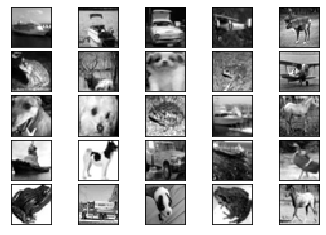

In [4]:
# display some random training images in a 25x25 grid    
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, data.shape[0])
        ax[m, n].imshow(data[idx], cmap='gray')
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
    f.subplots_adjust(hspace=0.1)
    f.subplots_adjust(wspace=0)

In [5]:
data.shape

(60000, 32, 32)

In [6]:
# Reshape images to be in R(1024) instead of R(32x32)
data = data.reshape(data.shape[:-2] + (-1,))
data.shape

(60000, 1024)

## $$Make Batches$$

In [7]:
def make_batches(data, batch_size):
    batches = list()
    chunks = (data.shape[0] - 1) // batch_size + 1
    for i in range(chunks):
         batches.append(data[i*batch_size:(i+1)*batch_size])
    return batches

In [8]:
batch_size = 8

In [9]:
batches = make_batches(data, batch_size)

In [10]:
len(batches)

7500

## $$Implementation$$
![](assets/algorithm.png)

In [11]:
from tqdm.notebook import tqdm
from scipy.linalg import eigh as largest_eigh

In [12]:
def top_k_eigenvectors(matrix, k):
    """
    params: matrix: matrix
            k: number of top vector to extract
    return: top k eignvectors based on eignvalues
    """
    N = matrix.shape[0]
    return largest_eigh(matrix, eigvals=(N-k,N-1))[1]

In [13]:
def compute_segma_hat(x):
    """
    Compute the segma hat that can run nodes(slaves)
    params: x: batch of the data
    return: segma hat
    """
    # the K leading eigenvectors of Σ = 1/n * sum{X @ X.T} over n
    n, d = x.shape
    segma_hat = np.zeros((d,d))
    segma_hat += np.dot(x, x.T)
    segma_hat /= n
    return segma_hat

In [14]:
m = 10 # Number of nodes to send batches to it
T = 10 # Time steps that pass
k = 2 # Target dimenssion 
d = batches[0].shape[1] # Dimenssion of orignal data

# slave work done list
v_hat_list = list()

segma_e = np.zeros((d, d)) # R(d x d)

# For t=1 to T:
for t in tqdm(range(1, T)):
    # Input : online data X
    # for l ← 1 to m: slaves work
    for l in range(m):
        # Compute V
        segma_hat = compute_segma_hat(batches[l])
        v_hat = top_k_eigenvectors(segma_hat, k) # R(d x k)
        
        # work done by the slave
        v_hat_list.append(v_hat)
    
    # Compute Σ bar (t) = 1/m sum{V dot V.T} over m    
    segma_bar = np.zeros((d, d)) # R(d x d)
    for l in range(m):
        segma_bar += v_hat_list[l] @ v_hat_list[l].T # R(k x k)
    segma_bar /= m
    
    # Update Σ e at (t) = Σ e at (t − 1) + 1/t v_dash dot v_dash.T
    v_dash = top_k_eigenvectors(segma_bar, k) # R(d x k)
    segma_e = segma_e + (1/(t+1)) * v_dash @ v_dash.T # R(d x d)

In [15]:
matrix_w = top_k_eigenvectors(segma_e, k)

In [16]:
matrix_w.shape

(1024, 2)

In [17]:
online_distributed_PCA = lambda X: X@matrix_w

In [18]:
online_PCA = online_distributed_PCA(data)

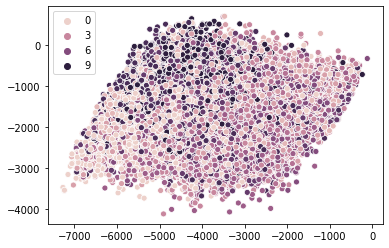

In [19]:
sns.scatterplot(x=online_PCA[:,0], y=online_PCA[:,1], hue=labels)

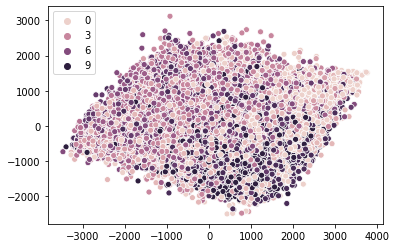

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data)
pca_transformed = pca.transform(data)
sns.scatterplot(x=pca_transformed[:,0], y=pca_transformed[:,1], hue=labels)